In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with  open("data/layer1/enhancer.cv.txt") as f:
       enhancer_cv = f.readlines()
       enhancer_cv = [s.strip() for s in enhancer_cv]
with  open("data/layer1/enhancer.ind.txt") as f:
       enhancer_ind = f.readlines()
       enhancer_ind = [s.strip() for s in enhancer_ind]
with  open("data/layer1/non.cv.txt") as f:
       non_cv = f.readlines()
       non_cv = [s.strip() for s in non_cv]
with  open("data/layer1/non.ind.txt") as f:
       non_ind = f.readlines()
       non_ind = [s.strip() for s in non_ind]

In [3]:
with  open("data/layer2/strong_742.txt") as f:
       strong_742 = f.readlines()
       strong_742 = [s.strip() for s in strong_742]
with  open("data/layer2/weak_742.txt") as f:
       weak_742 = f.readlines()
       weak_742 = [s.strip() for s in weak_742]
with  open("data/layer2/strong_100.txt") as f:
       strong_100 = f.readlines()
       strong_100 = [s.strip() for s in strong_100]
with  open("data/layer2/weak_100.txt") as f:
       weak_100 = f.readlines()
       weak_100 = [s.strip() for s in weak_100]
    
len(strong_742),len(weak_742),len(strong_100),len(weak_100)

(3710, 3710, 500, 500)

In [4]:
def remove_name_1(data):
    data_new = []
    for i in range(1,len(data),2):
        data_new.append(data[i])
    return data_new

In [5]:
def remove_name_2(data):
    data_new = []
    for i in range(1,len(data),5):
        data_new.append(data[i].upper()+data[i+1].upper()+data[i+2].upper()+data[i+3].upper())
    return data_new

In [6]:
enhancer_cv = remove_name_1(enhancer_cv)
non_cv = remove_name_1(non_cv)
enhancer_ind = remove_name_1(enhancer_ind)
non_ind = remove_name_1(non_ind)
print(len(enhancer_cv),len(enhancer_cv[0]))
print(len(enhancer_ind),len(enhancer_ind[0]))
print(len(non_cv),len(non_cv[0]))
print(len(non_ind),len(non_ind[0]))
train_x = np.concatenate([enhancer_cv, non_cv], axis=0)
test_x = np.concatenate([enhancer_ind, non_ind], axis=0)
print(len(train_x),len(test_x))

1484 200
200 200
1484 200
200 200
2968 400


In [7]:
strong_742 = remove_name_2(strong_742)
weak_742 = remove_name_2(weak_742)
strong_100 = remove_name_2(strong_100)
weak_100 = remove_name_2(weak_100)
print(len(strong_742),len(strong_742[0]))
print(len(weak_742),len(weak_742[0]))
print(len(strong_100),len(strong_100[0]))
print(len(weak_100),len(weak_100[0]))
train_x_1484 = np.concatenate([strong_742, weak_742], axis=0)
test_x_200 = np.concatenate([strong_100, weak_100], axis=0)
print(len(train_x_1484),len(test_x_200))

742 200
742 200
100 200
100 200
1484 200


In [8]:
train_y = np.concatenate([np.ones((len(enhancer_cv),)), np.zeros((len(non_cv),))], axis=0)  #竖向拼接
test_y = np.concatenate([np.ones((len(enhancer_ind),)), np.zeros((len(non_ind),))], axis=0)
print(train_y.shape,test_y.shape)

(2968,) (400,)


In [9]:
train_y_1484 = np.concatenate([np.ones((len(strong_742),)), np.zeros((len(weak_742),))], axis=0)  #竖向拼接
test_y_200 = np.concatenate([np.ones((len(strong_100),)), np.zeros((len(weak_100),))], axis=0)
print(train_y_1484.shape,test_y_200.shape)

(1484,) (200,)


In [11]:
def encode_matrix(seq_matrix):
    """将字符编码为整数
    """
    ind_to_char = ['A','T','C','G','N']
    char_to_ind = {char: i for i, char in enumerate(ind_to_char)}
    return [[char_to_ind[i] for i in s] for s in seq_matrix]

In [12]:
train_x = encode_matrix(train_x)
test_x = encode_matrix(test_x)
train_x = np.array(train_x)
test_x = np.array(test_x)
print(train_x.shape,test_x.shape)

(2968, 200) (400, 200)


In [13]:
train_x_1484 = encode_matrix(train_x_1484)
test_x_200 = encode_matrix(test_x_200)
train_x_1484 = np.array(train_x_1484)
test_x_200 = np.array(test_x_200)
print(train_x_1484.shape,test_x_200.shape)

(1484, 200) (200, 200)


In [14]:
#定义SN、SP、ACC、MCC
def sn_sp_acc_mcc(true_label,predict_label,pos_label=1):
    import math
    pos_num = np.sum(true_label==pos_label)
    print('pos_num=',pos_num)
    neg_num = true_label.shape[0]-pos_num
    print('neg_num=',neg_num)
    tp =np.sum((true_label==pos_label) & (predict_label==pos_label))
    print('tp=',tp)
    tn = np.sum(true_label==predict_label)-tp
    print('tn=',tn)
    sn = tp/pos_num
    sp = tn/neg_num
    acc = (tp+tn)/(pos_num+neg_num)
    fn = pos_num - tp
    fp = neg_num - tn
    print('fn=',fn)
    print('fp=',fp)
    
    tp = np.array(tp,dtype=np.float64)
    tn = np.array(tn,dtype=np.float64)
    fp = np.array(fp,dtype=np.float64)
    fn = np.array(fn,dtype=np.float64)
    mcc = (tp*tn-fp*fn)/(np.sqrt((tp+fn)*(tp+fp)*(tn+fp)*(tn+fn)))
    return sn,sp,acc,mcc

In [16]:
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
#https://zhuanlan.zhihu.com/p/97525394
class Attention3d(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        #self.supports_masking = True
        

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention3d, self).__init__(**kwargs)
    def get_config(self):
         config = {"W_regularizer":self.W_regularizer,
                   "b_regularizer":self.b_regularizer,"W_constraint":self.W_constraint,"b_constraint":self.b_constraint,
                    "bias":self.bias,"step_dim":self.step_dim,"features_dim":self.features_dim}
         base_config = super(Attention3d, self).get_config()
         return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=initializers.get('glorot_uniform'),
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [17]:
def resnet_identity_block(input_data, filters, kernel_size):
    # CNN层
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(input_data)
    x = BatchNormalization()(x)  #批次标准化
    x = Activation('relu')(x)
    # 第二层没有激活函数
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    # 两个张量相加
    x = Add()([x, input_data])
    # 对相加的结果使用ReLU激活
    x = Activation('relu')(x)
    # 返回结果
    return x

def resnet_convolutional_block(input_data, filters, kernel_size):
    # CNN层
    x = Conv1D(filters, kernel_size, strides=2, padding='valid')(input_data)
    x = BatchNormalization()(x)  #批次标准化
    x = Activation('relu')(x)
    # 第二层没有激活函数
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    X = Conv1D(filters, kernel_size, strides=2, padding='valid')(input_data)
    # 两个张量相加
    x = Add()([x, X])
    # 对相加的结果使用ReLU激活
    x = Activation('relu')(x)
    # 返回结果
    return x

In [18]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding,Dense,Flatten,Dropout,Add,Bidirectional,LSTM,Conv1D,GlobalMaxPool1D,MaxPooling1D,BatchNormalization,Activation,Reshape
import tensorflow as tf

def define_model():
    maxlen = 200
    max_features = 5
    embedding_dims = 32
    class_num = 1
    last_activation = 'sigmoid'
    input = Input((maxlen,))
    embedding = Embedding(max_features, embedding_dims, input_length=maxlen)(input)
    y = Conv1D(32, 8, strides=1, padding='same')(embedding)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=2, strides=1)(y)
    y = resnet_convolutional_block(y, 64, 8)   #卷积残差快  https://blog.csdn.net/qq_31050167/article/details/79161077
    y = resnet_identity_block(y, 64, 8)   #恒等残差块
    y = resnet_identity_block(y, 64, 8) 
    y = GlobalMaxPool1D()(y)

    x = Bidirectional(LSTM(32, return_sequences=True))(embedding)  # LSTM
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Attention3d(maxlen)(x)
    x = Dropout(0.5)(x)

    t = tf.keras.layers.Concatenate()([x,y])
    t = Dense(16,activation='relu')(t)
    output = Dense(class_num, activation=last_activation)(t)
    model = Model(inputs=input, outputs=output)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

In [19]:
#第一层
model_layer1 = define_model()
#第二层
model_layer2 = define_model()

In [20]:
model_layer1.load_weights('ResNet+LSTM+Attention(layer1).h5')
model_layer2.load_weights('ResNet+LSTM+Attention(layer2).h5')

pos_num= 200
neg_num= 200
tp= 159
tn= 163
fn= 41
fp= 37
(0.795, 0.815, 0.805, 0.6101220366122043)
pos_num= 100
neg_num= 100
tp= 99
tn= 80
fn= 1
fp= 20
(0.99, 0.8, 0.895, 0.8046575696136522)
0.85875
0.9637


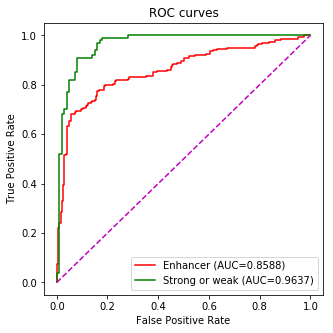

In [21]:
res1 = model_layer1.predict(test_x)     #预测
pred1 = np.squeeze(res1,axis=-1)
f1 = pred1>0.5
pred1[f1]=1
pred1[pred1<0.6]=0
sn_sp_acc_mcc1 = sn_sp_acc_mcc(test_y,pred1,pos_label=1)
print(sn_sp_acc_mcc1)

res2 = model_layer2.predict(test_x_200)     #预测
pred2 = np.squeeze(res2,axis=-1)
f2 = pred2>0.5
pred2[f2] = 1
pred2[pred2<0.6] = 0
sn_sp_acc_mcc2 = sn_sp_acc_mcc(test_y_200,pred2,pos_label=1)
print(sn_sp_acc_mcc2)

from sklearn.metrics import roc_curve,auc
FPR_1,TPR_1,threshold_1 = roc_curve(test_y,model_layer1.predict(test_x),pos_label=1)
FPR_2,TPR_2,threshold_2 = roc_curve(test_y_200,model_layer2.predict(test_x_200),pos_label=1)
#AUC值计算
AUC_1 = auc(FPR_1,TPR_1)
AUC_2 = auc(FPR_2,TPR_2)
print(AUC_1)
print(AUC_2)
#ROC曲线绘制
plt.figure(figsize=(5,5))
plt.title('ROC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.plot(FPR_1,TPR_1,color='r',label='Enhancer (AUC={:.4f})'.format(AUC_1))
plt.plot(FPR_2,TPR_2,color='g',label='Strong or weak (AUC={:.4f})'.format(AUC_2))
plt.plot([0, 1], [0, 1], color='m', linestyle='--')
plt.legend(loc='lower right')
# plt.savefig('layer1+layer2：Independent test ROC curves.png',dpi=300)
# plt.savefig('layer1+layer2：Independent test ROC curves.pdf',dpi=300)
# plt.savefig('layer1+layer2：Independent test ROC curves.jpg',dpi=300)
plt.show()